# Speed Detection

##### This solution uses the opencv2 optical flow dense implementation based on Gunner Farneback’s algorithm. 
##### Optical flow is computed for successive pairs of frames and used as input to a CNN using an Nvidia architecture.

In [212]:
import cv2
import glob2
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from natsort import natsorted

IMG_SIZE = (220,66)
RANDOM_STATE = 12

In [204]:
def implot(path: str, figsize = (10,5)):
    """
        plot image
    """
    plt.figure(figsize=figsize)
    if type(path) == str:
        img = cv2.imread(path)
        title = path.split('/')[-1]
    else:
        img = path
        title="Image"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # to hide tick values on X and Y axis
    plt.show()

In [211]:
import functools
from time import perf_counter

def perf_time(func):
    @functools.wraps(func)
    def wrap_decorator(*args, **kwargs):
        start = perf_counter()
        value = func(*args, **kwargs)
        end = perf_counter()
        execution_time = (end - start)
        print(f'Runtime: {execution_time:.2f}s / {execution_time/60:.2f}mins')
        return value
    return wrap_decorator

In [38]:
def create_frame_data(path: str):
    """
        Create DataFrame containing paths, time indexes and speeds for all frames
        
        path - relative path to frame data
    """
    # Data Preparation
    frames = glob2.glob(f"data/{path}/frame*.jpg") # image paths
    frames = natsorted(frames) # sorted paths
    
    # Frame speed values
    speed_file = open(f"data/{path}/{path}.txt")
    speed = [line.strip() for line in speed_file.readlines()]
    # Time index
    time = [i for i in range(len(speed))]
    
    data = pd.DataFrame(list(zip(time,frames,speed)), columns=['time_point','path','speed'], dtype=float)
    data = data.astype({'time_point': int, 'path': str})
    
    return data

In [39]:
data = create_frame_data('train')
data.head(5)

,time_point,path,speed
0,0,data/train\frame0.jpg,28.105569
1,1,data/train\frame1.jpg,28.105569
2,2,data/train\frame2.jpg,28.106527
3,3,data/train\frame3.jpg,28.130404
4,4,data/train\frame4.jpg,28.109243


## Train Data - Speed over Time

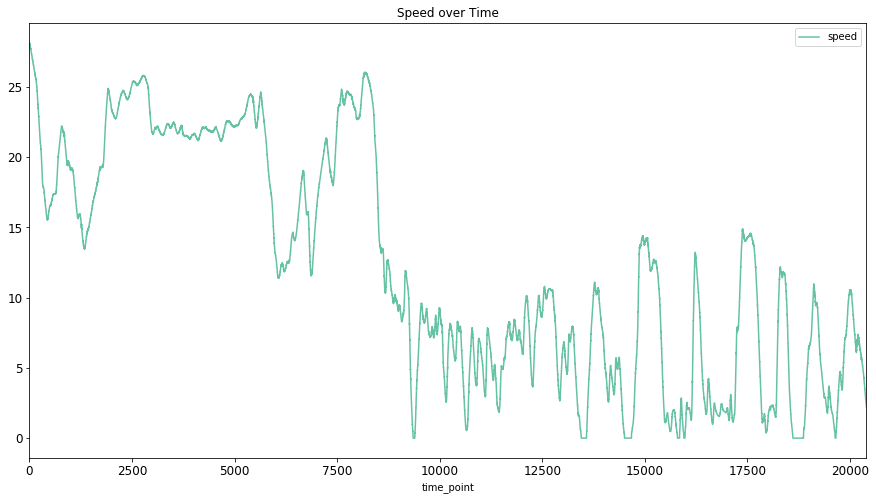

In [7]:
data[['time_point','speed']].plot(x='time_point', y='speed', figsize=(15,8), \
                                  fontsize=12, colormap='Set2', title='Speed over Time')
plt.show()

In [8]:
def optical_flow_dense(img, img_next):
    """
        Computes optical flow magnitude and angle and places it into HSV image
    
        img, img_next - RGB images
    """
    gray_current = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img_next = cv2.cvtColor(img_next, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros((IMG_SIZE[1], IMG_SIZE[0], 3))
    
    # set saturation
    hsv[...,1] = cv2.cvtColor(img_next, cv2.COLOR_RGB2HSV)[...,1]
    
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_img_next, None, 0.5, 1, 15, 2, 5, 1.2, 0) 
    # Compute magnite and angle of 2D vector 
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
    # Set image hue value according to the angle of optical flow 
    hsv[..., 0] = ang * 180 / np.pi / 2
    # Set value as per the normalized magnitude of optical flow 
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) 
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    # Convert to rgb 
    rgb_rep = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
 
    return rgb_rep

In [9]:
def normalise_image(image):
    """
        Normalize image
    """
    return (image / 255) - 0.5

In [121]:
@perf_time
def create_model_data(data, val_size: int):
    """
        Generate model data
        
        data - pandas dataFrame
        val_size - size of the validation set, to split the data
    """
    images = np.zeros((len(data), IMG_SIZE[1], IMG_SIZE[0], 3), dtype = np.float32)
    labels = np.zeros(len(data), dtype = np.float32)
    time_index = np.zeros(len(data), dtype = int)

    for i, time in enumerate(data['time_point']):
        if i < len(data) - 1:
            current = cv2.imread(data['path'][time])
            next = cv2.imread(data['path'][time + 1])
            
            speed_current = data['speed'][time]
            speed_next = data['speed'][time + 1]
            
            rgb_diff = optical_flow_dense(current, next)
            speed = np.mean([speed_current, speed_next])
            
            images[i] = rgb_diff
            labels[i] = speed
            time_index[i] = time
        else:
            break
    
    data = shuffle(images, labels, time_index, random_state=RANDOM_STATE)
    
    train = data[0][val_size:], data[1][val_size:], data[2][val_size:]
    valid = data[0][:val_size], data[1][:val_size], data[2][:val_size]
    
    return train, valid

In [54]:
def train_gen(train: list, batch_size: int):
    """
        Generate the training set
    
        train - training data from 'create_model_data'
        batch_size - size of each batch of data
    """
    images = np.zeros((batch_size, IMG_SIZE[1], IMG_SIZE[0], 3), dtype = np.float32)
    labels = np.zeros(batch_size, dtype = np.float32)
    while True:
        img, label =  train[0], train[1]
        l = [_ for _ in range(len(img) - 1)]
        for i in range(batch_size):
            index = random.sample(l, 1)[0]
            l.remove(index)
            images[i] = img[index]
            labels[i] = label[index]
        yield images, labels

In [14]:
def valid_gen(valid: list):
    """
        Generate the validation set
    
        valid - validation data from 'create_model_data'
    """
    while True:
        img, label =  valid[0], valid[1]
        for image, speed in zip(img, label):
            image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
            speed = np.array([speed])
            yield image, speed

# CNN Model

In [15]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU, BatchNormalization
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF

Using TensorFlow backend.


In [40]:
def model_():
    input_shape = (IMG_SIZE[1], IMG_SIZE[0], 3)

    model = Sequential()
    
    # normalization    
    model.add(Lambda(lambda image: normalise_image(image), input_shape = input_shape))
    
    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.25))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

# Train Model

In [205]:
#SET-UP
val_size = int(len(data) * 0.2)
train, valid = create_model_data(data, val_size)

Runtime: 308.63s / 5.14mins


In [ ]:
batch_size = 16
num_epochs = 8
train_size = int(len(data) - val_size)
steps_per_epoch = 400 #train_size // batch_size

train_generator = train_gen(train, batch_size)
valid_generator = valid_gen(valid)

model = model_()
model.load_weights('data/weights.h5') # Load model weights from a previously trained model
history = model.fit(
        train_generator, 
        epochs = num_epochs,
        steps_per_epoch = steps_per_epoch,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size
        )

# Evaluate Model on Validation

In [64]:
val_score = model.evaluate(valid_generator, steps=val_size)
print('val score:', val_score)

4080/4080 [==============================] - 26s 6ms/step
val score: 9.641554832458496


In [178]:
def model_predict(data, labels):
    """
        predict values using data
        
        data - validation/test sets
        labels - ground truth labels for validation/test sets
    """
    predictions = []
    errors = []
    
    for i, img in enumerate(data):
        img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
        pred = model.predict(img)[0]
        predictions.append(pred)
        errors.append(abs(pred-labels[i]))
        
    return predictions, errors

In [179]:
predictions, errors = model_predict(valid[0], valid[1])

In [162]:
results = pd.DataFrame(zip(valid[1], predictions, errors, valid[2]),\
                       columns=['True', 'Pred', 'Error','Time'], dtype=float).sort_values(by='Time')

In [229]:
def plot_prediction(data, y: str, y_hat:str, error: bool):
    """
        Plot predictions with ground truth and errors
    """
    plt.figure(figsize=(15,8))
    plt.plot(data['Time'], data[y_hat], 'c.')
    plt.plot(data['Time'], data[y], 'mo')
    if error:
        plt.plot(data['Time'], data['Error'], 'k.', alpha=0.4)
    plt.xlabel('Time Index')
    plt.ylabel('Speed')
    plt.title('Predicted vs Actual on Validation Data')
    plt.legend(['Predicted','Validation','Errors'], loc='upper right')
    plt.show()

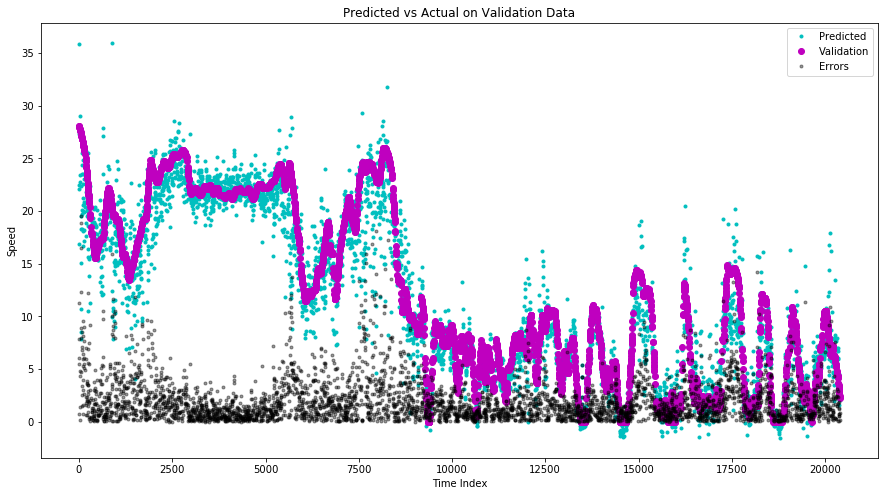

In [177]:
plot_prediction(results, 'True', 'Pred', True)

# Test model on Test Data

In [209]:
test = create_frame_data('test')
test.head(5)

,time_point,path,speed
0,0,data/test\frame0.jpg,15.619640
1,1,data/test\frame1.jpg,15.523605
2,2,data/test\frame2.jpg,15.162591
3,3,data/test\frame3.jpg,15.294366
4,4,data/test\frame4.jpg,15.265691


In [214]:
@perf_time
def create_test_data(data):
    """
        Generate model data
        
        data - pandas dataFrame
    """
    images = np.zeros((len(data), IMG_SIZE[1], IMG_SIZE[0], 3), dtype = np.float32)
    labels = np.zeros(len(data), dtype = np.float32)
    time_index = np.zeros(len(data), dtype = int)

    for i, time in enumerate(data['time_point']):
        if i < len(data) - 1:
            current = cv2.imread(data['path'][time])
            next = cv2.imread(data['path'][time + 1])
            
            speed_current = data['speed'][time]
            speed_next = data['speed'][time + 1]
            
            rgb_diff = optical_flow_dense(current, next)
            speed = np.mean([speed_current, speed_next])
            
            images[i] = rgb_diff
            labels[i] = speed
            time_index[i] = time
        else:
            break
    return images, labels, time_index

In [216]:
model_test = create_test_data(test)

Runtime: 129.70s / 2.16mins


In [219]:
predictions_, errors_ = model_predict(model_test[0], model_test[1])
test_results = pd.DataFrame(zip(model_test[1], predictions_, errors_, model_test[2]),\
                       columns=['True', 'Pred', 'Error','Time'], dtype=float).sort_values(by='Time')

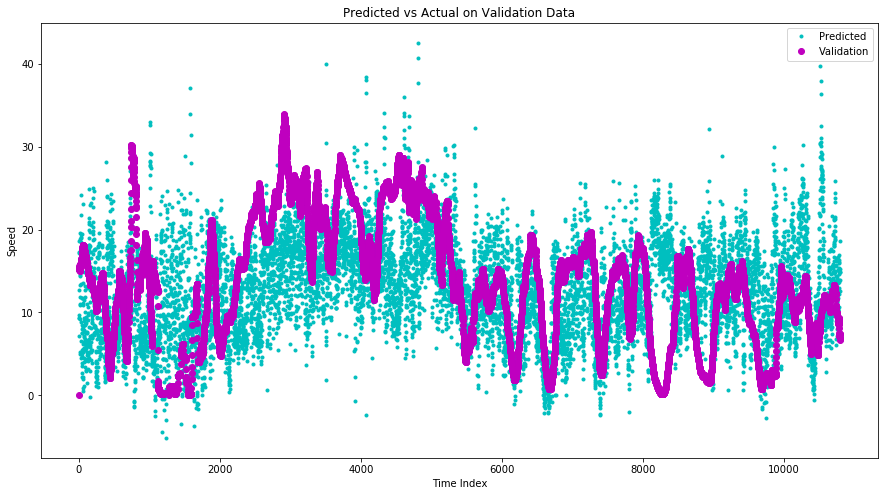

In [230]:
plot_prediction(test_results, 'True', 'Pred', False)